# Key Insights

In [ ]:
import sys

import humanize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from matplotlib.patches import Patch

sys.path.insert(0, "..")
from runner.utils import (
    load_benchmark_metadata,
)

In [4]:
results = pd.read_csv(open("../results/benchmark_results.csv"))

results["bench-size"] = results["Benchmark"] + "-" + results["Size"]
results["solver-version"] = results["Solver"] + "-" + results["Solver Version"]
print(
    f"Found {len(results)} records, {len(results['bench-size'].unique())} benchmark instances"
)

Found 2100 records, 156 benchmark instances


In [5]:
benchmarks_df = load_benchmark_metadata()

## Main Results

In [ ]:
# TODO replicate the results below. Categorize into sizes/realistic/LP-MILP, compute SGM, and plot. Also add num solved into plot

## How good is each solver and for what cases?

In [6]:
import pandas as pd
import yaml

results = pd.read_csv(open("../results/benchmark_results.csv"))
meta = yaml.safe_load(open("../results/metadata.yaml"))

results["bench-size"] = results["Benchmark"] + "-" + results["Size"]
results["solver-version"] = results["Solver"] + "-" + results["Solver Version"]

In [7]:
max_num_solvers = 5  # TODO

# Color map
color_map = {
    "cbc": "#F9CD5A",  # yellow
    "glpk": "#7C3AED",  # purple
    "gurobi": "#F66C49",  # red
    "highs": "#43BF94",  # green
    "scip": "#3B82F6",  # blue
}  # TODO change these colors on the website too!


def build_summary(results, meta):
    rows = []

    for _, r in results.iterrows():
        bench = r["Benchmark"]
        size = r["Size"]

        try:
            entry = meta["benchmarks"][bench]
            size_entry = next(x for x in entry["Sizes"] if x["Name"] == size)
        except Exception:
            continue

        realistic = bool(size_entry.get("Realistic", False))
        ncons = size_entry.get("Num. constraints", None)
        letter = size_entry.get("Size", None)
        problem_class = entry.get("Problem class", "Unknown")

        # --- determine size buckets (overlapping) ---
        buckets = []

        if letter == "S" or (ncons is not None and ncons < 100_000):
            buckets = ["Small"]

        elif letter == "M":
            buckets = ["Medium"]
            if realistic:
                buckets.append("Medium & realistic")

        elif letter == "L":
            buckets = ["Large"]
            if realistic:
                buckets.append("Large & realistic")

        # --- duplicate rows into buckets ---
        for b in buckets:
            row = r.copy()
            row["Benchmark"] = b
            row["Problem_class"] = problem_class
            rows.append(row)

    df = pd.DataFrame(rows)

    # --- SGM runtime: solved vs not solved ---
    df["Runtime_clean"] = np.where(
        df["Status"] == "ok",
        df["Runtime (s)"],
        df["Timeout"],
    ).astype(float)

    summary = (
        df.groupby(["Benchmark", "Problem_class", "Solver"])
        .agg(
            Runtime_s=("Runtime_clean", "mean"),
            Timeout=("Timeout", "max"),
            Num_problems=("Status", "count"),
            Solved_frac=("Status", lambda s: (s == "ok").mean()),
        )
        .reset_index()
    )

    # --- slowdown (normalized within Benchmark and Problem_class) ---
    summary["Slowdown"] = summary.groupby(["Benchmark", "Problem_class"])[
        "Runtime_s"
    ].transform(lambda s: s / s.min())

    return summary


BENCHMARK_ORDER = [
    "Small",
    "Medium",
    "Medium & realistic",
    "Large",
    "Large & realistic",
]


# --- Plotting function ---
def plot_runtime_slowdowns(df, figsize=(12, 6)):
    d = df.copy()

    sorted_groups = (
        d[["Benchmark", "Runtime_s"]].groupby("Benchmark", as_index=False).min()
    )

    sorted_groups["Benchmark"] = pd.Categorical(
        sorted_groups["Benchmark"],
        categories=BENCHMARK_ORDER,
        ordered=True,
    )

    sorted_groups = sorted_groups.sort_values("Benchmark")

    width = 1 / (max_num_solvers + 1)
    fig, ax = plt.subplots(figsize=figsize, layout="constrained")
    ax.axhline(1, color="grey", linestyle="--")

    for i, row in sorted_groups.iterrows():
        grp = row["Benchmark"]
        subset = d[(d["Benchmark"] == grp) & d["Runtime_s"].notna()].sort_values(
            "Slowdown"
        )
        if subset.empty:
            continue

        xs = i + (np.arange(len(subset)) * width) - 0.5 + width
        ax.bar(
            xs,
            subset["Slowdown"],
            width,
            color=[color_map[s] for s in subset["Solver"]],
        )

        for j, xval in enumerate(xs):
            y = subset.iloc[j]["Slowdown"] + 0.3
            ax.text(
                xval,
                y,
                f"{subset.iloc[j]['Slowdown']:.1f}x",
                ha="center",
                fontsize=9,
            )

    labels = []
    for _, row in sorted_groups.iterrows():
        grp = row["Benchmark"]
        sub = d[d["Benchmark"] == grp]

        fastest = sub["Runtime_s"].min()
        timeout = sub["Timeout"].max()

        num_series = sub.get("Num_problems")
        num = (
            int(num_series.max())
            if num_series is not None and num_series.notna().any()
            else None
        )

        timeout_str = (
            f"{int(timeout / 3600)} hr timeout"
            if timeout >= 3600
            else f"{timeout:.0f} s timeout"
        )

        if num is not None:
            labels.append(
                f"{grp} ({num} problems; {timeout_str})\nFastest: {int(fastest)} s"
            )
        else:
            labels.append(f"{grp}\nFastest: {int(fastest)} s")

    ax.set_xticks(np.arange(len(sorted_groups)), labels)

    if "Problem_class" in d.columns:
        first_bench = sorted_groups["Benchmark"].iloc[0]
        class_type = d[d["Benchmark"] == first_bench]["Problem_class"].iloc[0]
        title = f"Solver Runtime Comparison – {class_type}"
    else:
        title = "Solver Runtime Comparison"

    ax.set_title(title)
    ax.set_ylabel("Relative runtime (normalized)")
    ax.legend(handles=[Patch(color=c, label=s) for s, c in color_map.items()])

In [8]:
def filter_by_problem_class(results, meta, problem_class):
    """
    Filter raw results by problem class (e.g. 'LP' or 'MILP').

    Parameters
    ----------
    results : pd.DataFrame
        Raw benchmark results.
    meta : dict
        Benchmark metadata dictionary.
    problem_class : str
        Problem class to keep ('LP' or 'MILP').

    Returns
    -------
    pd.DataFrame
        Filtered results containing only the requested problem class.
    """
    return results[
        results["Benchmark"].apply(
            lambda b: meta["benchmarks"][b]["Problem class"] == problem_class
        )
    ]

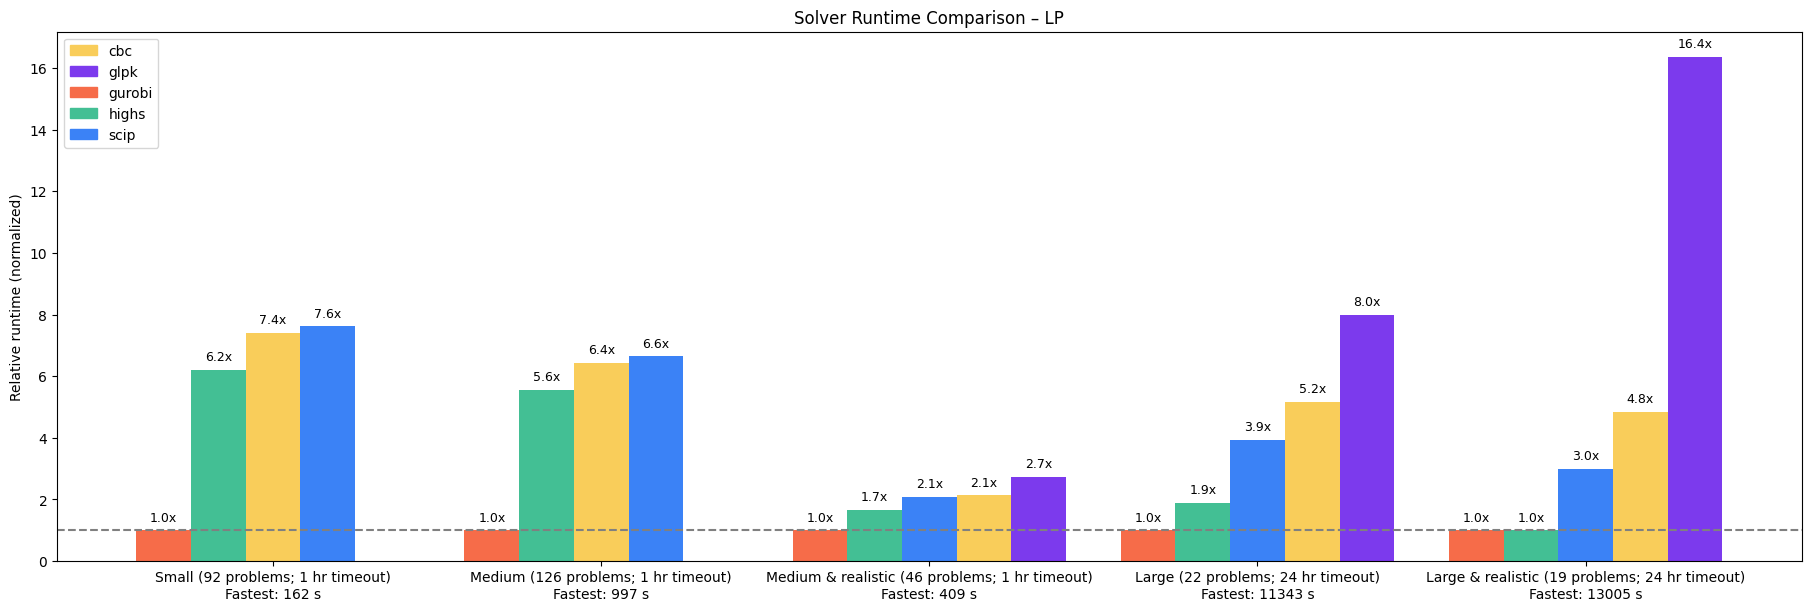

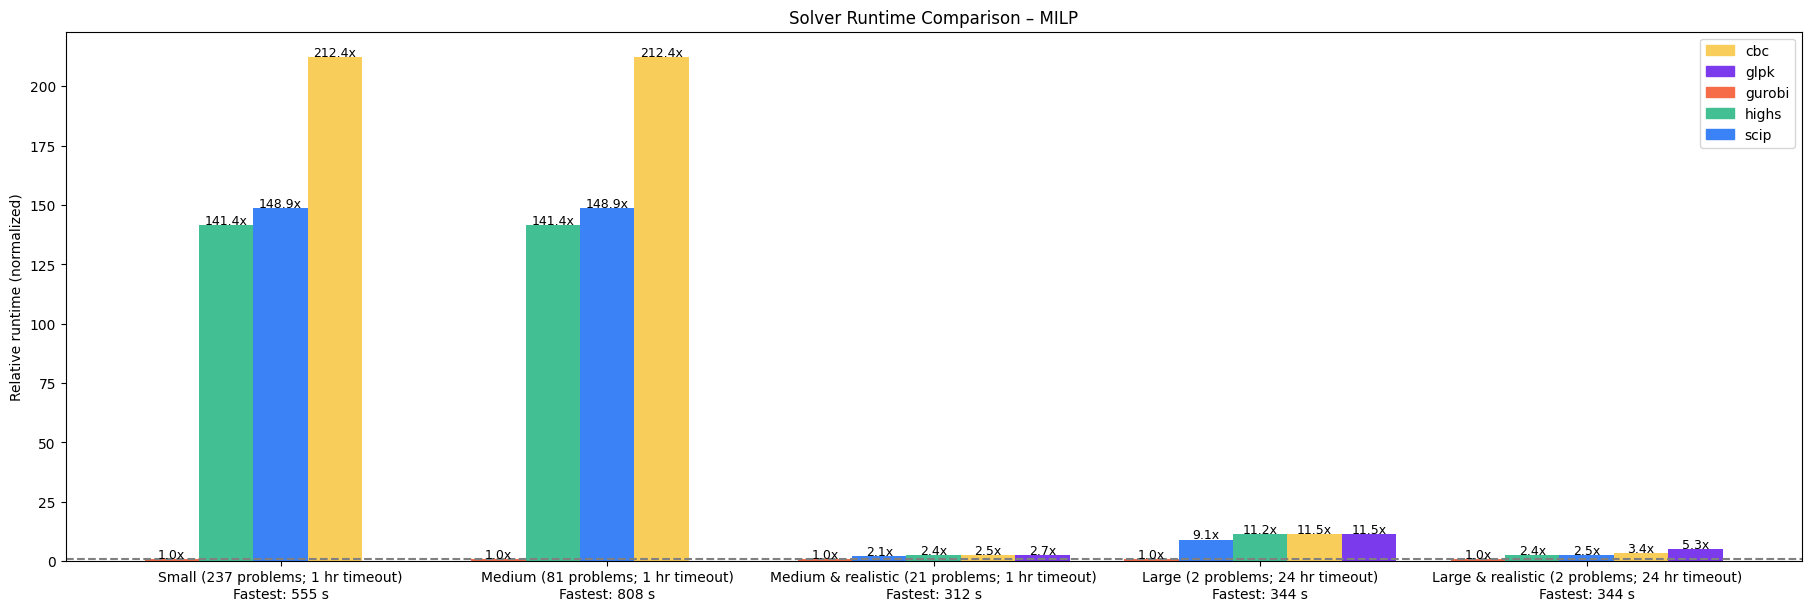

In [9]:
results = pd.read_csv("../results/benchmark_results.csv")
meta = yaml.safe_load(open("../results/metadata.yaml"))

results_lp = filter_by_problem_class(results, meta, "LP")
results_milp = filter_by_problem_class(results, meta, "MILP")

summary_lp = build_summary(results_lp, meta)
plot_runtime_slowdowns(summary_lp, figsize=(18, 6))

summary_milp = build_summary(results_milp, meta)
plot_runtime_slowdowns(summary_milp, figsize=(18, 6))

In [10]:
def build_leaderboard(summary, solver_versions):
    """
    Build a solver leaderboard table based on SGM runtime.

    Assumes `summary` is already:
    - SGM-correct
    - filtered by problem class (LP or MILP)
    - filtered by horizon (Short or Long)

    Required columns in summary:
    - Solver
    - Runtime_s
    - Solved_frac
    - Num_problems
    """

    tbl = (
        summary.groupby("Solver")
        .agg(
            SGM_Runtime_abs=("Runtime_s", "mean"),
            Solved_frac=("Solved_frac", "mean"),
            Num_problems=("Num_problems", "sum"),
        )
        .reset_index()
    )

    # Normalize runtime (best = 1)
    tbl["SGM_Runtime_rel"] = tbl["SGM_Runtime_abs"] / tbl["SGM_Runtime_abs"].min()

    # Solved benchmarks string: "94 % (17 / 18)"
    solved = (tbl["Solved_frac"] * tbl["Num_problems"]).round(0).astype(int)
    total = tbl["Num_problems"].astype(int)

    tbl["Solved Benchmarks"] = (
        (tbl["Solved_frac"] * 100).round(0).astype(int).astype(str)
        + " % ("
        + solved.astype(str)
        + " / "
        + total.astype(str)
        + ")"
    )

    # Pretty runtime formatting: "1.00 (92.01)"
    tbl["SGM Runtime"] = (
        tbl["SGM_Runtime_rel"].round(2).astype(str)
        + " ("
        + tbl["SGM_Runtime_abs"].round(2).astype(str)
        + ")"
    )

    # Solver versions
    tbl["Version"] = tbl["Solver"].map(solver_versions)

    # Ranking
    tbl = tbl.sort_values("SGM_Runtime_abs").reset_index(drop=True)
    tbl.insert(0, "Rank", tbl.index + 1)

    return tbl[
        [
            "Rank",
            "Solver",
            "Version",
            "Solved Benchmarks",
            "SGM Runtime",
        ]
    ]

In [11]:
def extract_solver_versions(results):
    return (
        results.sort_values("Solver Release Year")
        .drop_duplicates("Solver", keep="last")
        .set_index("Solver")["Solver Version"]
        .to_dict()
    )


solver_versions = extract_solver_versions(results)

In [12]:
# LP
display(Markdown("### LP – Short"))
display(
    build_leaderboard(
        summary_lp[~summary_lp["Benchmark"].str.startswith("Large")],
        solver_versions,
    ).style.hide(axis="index")
)

display(Markdown("### LP – Long"))
display(
    build_leaderboard(
        summary_lp[summary_lp["Benchmark"].str.startswith("Large")],
        solver_versions,
    ).style.hide(axis="index")
)

# MILP
display(Markdown("### MILP – Short"))
display(
    build_leaderboard(
        summary_milp[~summary_milp["Benchmark"].str.startswith("Large")],
        solver_versions,
    ).style.hide(axis="index")
)

display(Markdown("### MILP – Long"))
display(
    build_leaderboard(
        summary_milp[summary_milp["Benchmark"].str.startswith("Large")],
        solver_versions,
    ).style.hide(axis="index")
)

### LP – Short

Rank,Solver,Version,Solved Benchmarks,SGM Runtime
1,gurobi,13.0.0,93 % (245 / 264),1.0 (523.42)
2,highs,1.12.0,80 % (212 / 264),1.65 (864.5)
3,scip,10.0.0,70 % (183 / 260),2.66 (1393.69)
4,cbc,2.10.12,56 % (75 / 134),3.2 (1676.72)
5,glpk,5.0,21 % (14 / 65),5.52 (2890.04)


### LP – Long

Rank,Solver,Version,Solved Benchmarks,SGM Runtime
1,gurobi,13.0.0,90 % (37 / 41),1.0 (12174.68)
2,highs,1.12.0,27 % (11 / 41),5.86 (71302.29)
3,cbc,2.10.12,5 % (2 / 41),6.88 (83766.21)
4,scip,10.0.0,0 % (0 / 41),7.1 (86400.0)


### MILP – Short

Rank,Solver,Version,Solved Benchmarks,SGM Runtime
1,gurobi,13.0.0,88 % (298 / 339),1.0 (558.99)
2,scip,10.0.0,69 % (230 / 332),3.55 (1983.6)
3,highs,1.12.0,46 % (156 / 339),4.05 (2265.9)
4,cbc,2.10.12,35 % (61 / 173),4.51 (2521.35)
5,glpk,5.0,22 % (19 / 83),5.2 (2908.58)


### MILP – Long

Rank,Solver,Version,Solved Benchmarks,SGM Runtime
1,gurobi,13.0.0,100 % (4 / 4),1.0 (344.44)
2,highs,1.12.0,50 % (2 / 4),141.42 (48709.68)
3,scip,10.0.0,50 % (2 / 4),148.85 (51270.47)
4,cbc,2.10.12,50 % (2 / 4),212.4 (73157.92)


In [13]:
# from io import StringIO
#
## SGM results
# data = """Benchmark,Solver,Runtime (s),Status,Timeout
# Small (18 problems; 1 hr timeout),gurobi,16.1,ok
# Small (18 problems; 1 hr timeout),highs,94.61,ok
# Small (18 problems; 1 hr timeout),scip,68.89,ok
# Small (18 problems; 1 hr timeout),cbc,349.43,ok
# Small (18 problems; 1 hr timeout),glpk,963.3,ok
# Medium (87 problems; 1 hr timeout),gurobi,125.25,ok
# Medium (87 problems; 1 hr timeout),highs,560.11,ok
# Medium (87 problems; 1 hr timeout),scip,659.39,ok
# Medium (87 problems; 1 hr timeout),cbc,899.76,ok
# Medium (87 problems; 1 hr timeout),glpk,1761.3,ok
# Medium & realistic (19 problems; 1 hr timeout),gurobi,54.86,ok
# Medium & realistic (19 problems; 1 hr timeout),highs,220.96,ok
# Medium & realistic (19 problems; 1 hr timeout),scip,267.89,ok
# Medium & realistic (19 problems; 1 hr timeout),cbc,1445.51,ok
# Medium & realistic (19 problems; 1 hr timeout),glpk,3189.2,ok
# Large (15 problems; 10 hr timeout),gurobi,1124.64,ok
# Large (15 problems; 10 hr timeout),highs,25793.13,ok
# Large (15 problems; 10 hr timeout),scip,31847.48,ok
# Large (15 problems; 10 hr timeout),cbc,35747.02,ok
# Large & realistic (13 problems; 10 hr timeout),gurobi,1235.35,ok
# Large & realistic (13 problems; 10 hr timeout),highs,28762.75,ok
# Large & realistic (13 problems; 10 hr timeout),scip,31252.59,ok
# Large & realistic (13 problems; 10 hr timeout),cbc,35708.26,ok
# """
# df = pd.read_csv(StringIO(data))
#
## TODO add num solved as fraction
#
# plot_runtime_slowdowns(df, figsize=(18, 6))

### Canonical / representative / featured problems

In [14]:
def build_summary_representative(results):
    """
    Summary for representative problems:
    - solved-only runtime
    - TO for non-solved
    - slowdown relative to fastest solved solver (per benchmark)
    """
    df = results.copy()
    df["Benchmark"] = df["bench-size"]

    # solved-only runtime
    df["Runtime_clean"] = np.where(
        df["Status"] == "ok",
        df["Runtime (s)"],
        np.nan,
    )

    summary = (
        df.groupby(["Benchmark", "Solver"])
        .agg(
            Runtime_s=("Runtime_clean", "mean"),
            Timeout=("Timeout", "max"),
            Status=("Status", lambda s: "ok" if (s == "ok").any() else s.iloc[0]),
        )
        .reset_index()
    )

    summary["Slowdown"] = summary.groupby("Benchmark")["Runtime_s"].transform(
        lambda s: s / s.min()
    )

    return summary

In [15]:
def plot_representative_runtime(summary, figsize=(20, 6), cap=80):
    fig, ax = plt.subplots(figsize=figsize, layout="constrained")

    benchmark_order = order_benchmarks_by_fastest(summary)

    for i, bench in enumerate(benchmark_order):
        sub = summary[summary["Benchmark"] == bench].copy()

        # split solved / unsolved
        solved = sub.dropna(subset=["Runtime_s"]).sort_values("Runtime_s")
        unsolved = sub[sub["Runtime_s"].isna()]

        ordered = pd.concat([solved, unsolved], ignore_index=True)

        width = 0.8 / len(ordered)

        fastest_runtime = solved["Runtime_s"].min()
        fastest_minutes = fastest_runtime / 60

        for j, row in ordered.iterrows():
            solver = row["Solver"]
            x = i + j * width - 0.4

            if pd.isna(row["Runtime_s"]):
                y = cap
                label = "TO"
                label_color = "red"
            else:
                y = row["Runtime_s"] / fastest_runtime
                label = f"{y:.1f}x"
                label_color = "black"

            ax.bar(
                x,
                y,
                width,
                color=color_map.get(solver, "gray"),
                alpha=0.85,
            )

            ax.text(
                x,
                y + 1,
                label,
                ha="center",
                va="bottom",
                fontsize=9,
                color=label_color,
            )

        # annotation under benchmark
        ax.text(
            i,
            -7,
            f"Fastest solver: {fastest_minutes:.0f} mins",
            ha="center",
            va="top",
            fontsize=9,
        )

    ax.axhline(1, color="grey", linestyle="--")
    ax.set_ylabel("Runtime relative to fastest solver")

    ax.set_xticks(range(len(benchmark_order)))
    ax.set_xticklabels(benchmark_order, ha="right")

    ax.set_ylim(-10, cap + 5)
    ax.set_yticks([1, 10, 20, 40, 60, 80])

    # legend (still global)
    ax.legend(
        handles=[Patch(color=color_map[s], label=s.capitalize()) for s in color_map],
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=len(color_map),
        frameon=False,
    )

    return fig, ax

In [16]:
def order_benchmarks_by_fastest(summary):
    fastest = (
        summary.dropna(subset=["Runtime_s"])
        .groupby("Benchmark")["Runtime_s"]
        .min()
        .sort_values()
    )
    return list(fastest.index)

In [17]:
## Old set of representative problems
#
# to_plot = {
#    "pypsa-eur-elec-op-10-3h",
#    "pypsa-eur-sec-5-12h",
#    "genx-10_IEEE_9_bus_DC_OPF-9-1h",
#    "genx-elec_trex_uc-15-24h",
#    "tulipa-1_EU_investment_simple-28-1h",
#    "temoa-US_9R_TS_SP-9-12",
#    "TIMES-GEO-global-netzero-31-20ts",
# }

to_plot = [
    "genx-10_IEEE_9_bus_DC_OPF-9-1h",
    "pypsa-eur-sec-50-1h",
    "pypsa-eur-elec-50-1h",
    "temoa-US_9R_TS_SP-9_12ts",
    "SWITCH-China-open-model-32-433ts",
    "ethos_fine_europe_60tp-175-720ts",
    "TIMES-GEO-global-netzero-31-20ts",
]

In [18]:
to_plot_results = results[results["bench-size"].isin(to_plot)]

to_plot_results = to_plot_results.sort_values(
    ["bench-size", "Solver", "Solver Release Year"]
).drop_duplicates(["bench-size", "Solver"], keep="last")

(<Figure size 2000x600 with 1 Axes>,
 <Axes: ylabel='Runtime relative to fastest solver'>)

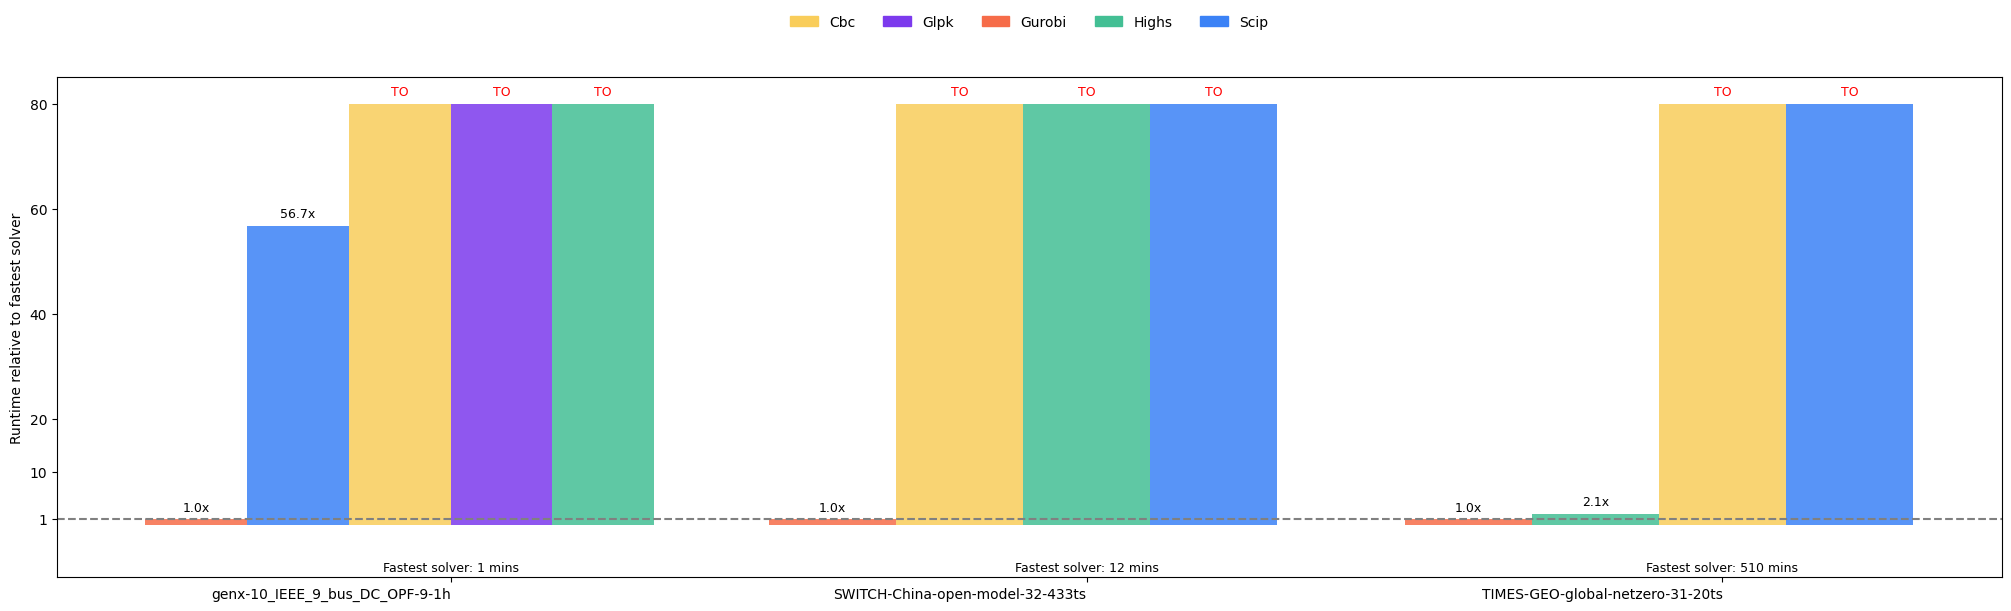

In [19]:
summary_subset = build_summary_representative(to_plot_results)

plot_representative_runtime(
    summary_subset,
    figsize=(20, 6),
    cap=80,
)

In [20]:
# times_problems = [
#    "times-etimeseu-france-elec+heat-co2-multi_stage",
#    "TIMES-GEO-global-netzero",
#    "times-etimeseu-france-elec+heat-multi_stage",
#    "times-etimeseu-france-elec+heat-co2-single_stage",
#    "times-ireland-noco2",
#    "times-etimeseu-europe-elec+heat-multi_stage",
#    "times-etimeseu-europe-elec+heat-co2-multi_stage",
#    "times-etimeseu-europe-elec+heat-co2-single_stage",
#    "TIMES-GEO-global-base",
#    "times-nz-tui",
#    "times-etimeseu-france-elec+heat-single_stage",
#    "times-ireland-noco2-counties",
#    "times-etimeseu-europe-elec+heat-single_stage",
#    "times-nz-kea",
# ]
# times_to_plot = {
#    "TIMES-GEO-global-netzero",
#    "times-etimeseu-europe-elec+heat-co2-multi_stage",
#    "times-nz-kea",
#    "times-ireland-noco2-counties",
#    "temoa-US_9R_TS_NZ",
# }
# times_results = results[results["Benchmark"].isin(times_to_plot)]
#
## Fix size names
# times_results.loc[
#    times_results.query('`bench-size` == "times-ireland-noco2-counties-26-1h"').index,
#    "bench-size",
# ] = "times-ireland-noco2-counties-26-1ts"
# times_results.loc[
#    times_results.query('`bench-size` == "times-nz-kea-2-24h"').index, "bench-size"
# ] = "times-nz-kea-2-24ts"
#
## Remove old solver versions
# times_results = times_results.sort_values(
#    ["bench-size", "Solver", "Solver Release Year"]
# ).drop_duplicates(["bench-size", "Solver"], keep="last")
#
# plot_runtime_slowdowns(times_results, figsize=(20, 6))

## What's feasible for open source solvers?

In [21]:
def build_summary_single_benchmark(results):
    """
    Summary for largest / representative benchmarks.

    - solved-only runtime
    - TO / ER kept as NaN
    - slowdown relative to fastest solved solver
    """
    df = results.copy()
    df["Benchmark"] = df["bench-size"]

    df["Runtime_clean"] = np.where(
        df["Status"] == "ok",
        df["Runtime (s)"],
        np.nan,
    )

    summary = (
        df.groupby(["Benchmark", "Solver"])
        .agg(
            Runtime_s=("Runtime_clean", "mean"),
            Status=("Status", lambda s: "ok" if (s == "ok").any() else s.iloc[0]),
        )
        .reset_index()
    )

    summary["Slowdown"] = summary.groupby("Benchmark")["Runtime_s"].transform(
        lambda s: s / s.min()
    )

    return summary

In [22]:
# Make a table of metadata
meta_data = []
for n, b in meta["benchmarks"].items():
    for s in b["Sizes"]:
        bench_size = n + "-" + s["Name"]
        meta_data.append(
            (
                bench_size,
                b["Problem class"],
                b["Modelling framework"],
                s["Num. variables"],
                s["Num. constraints"],
                s["Spatial resolution"],
                s["Temporal resolution"],
            )
        )
metadata_df = pd.DataFrame(
    meta_data,
    columns=[
        "bench-size",
        "Problem Class",
        "Modelling Framework",
        "Num. Variables",
        "Num. Constraints",
        "Spatial Resolution",
        "Temporal Resolution",
    ],
)

# Merge to get a table with bench-size, fastest os solver, runtime, num vars, num constraints, temp/spatial resolutions
results_n_meta = results.join(metadata_df.set_index("bench-size"), on="bench-size")
results_n_meta["Runtime"] = results_n_meta["Runtime (s)"].apply(humanize.naturaldelta)

# First get the fastest OS solver for each bench-size
os_feasible_results = (
    results_n_meta.query("Solver != 'gurobi' and Status == 'ok'")
    .sort_values("Runtime (s)")
    .drop_duplicates(["bench-size"])
)

# The fastest Gurobi solver for each bench-size
gurobi_results = (
    results_n_meta.query("Solver == 'gurobi' and Status == 'ok'")
    .sort_values("Runtime (s)")
    .drop_duplicates(["bench-size"])
)

cols_of_interest = [
    "Benchmark",
    "Size",
    "Num. Variables",
    "Num. Constraints",
    "Spatial Resolution",
    "Temporal Resolution",
    "Solver",
    "Solver Version",
    "Runtime",
]

In [23]:
# collapse Gurobi runtimes per benchmark
gurobi_best = (
    results.query('Solver == "gurobi"')
    .sort_values(["bench-size", "Solver Release Year"], ascending=[True, False])
    .drop_duplicates(["bench-size"])[["bench-size", "Runtime (s)"]]
    .rename(columns={"Runtime (s)": "Runtime (s) - Gurobi"})
    .set_index("bench-size")
)

# join WITHOUT duplicating rows (safe)
os_feasible_results = os_feasible_results.join(
    gurobi_best,
    on="bench-size",
    how="left",
    rsuffix="_dup",  # avoid column overlap failure
)

# humanized formatted runtime
os_feasible_results["Runtime - Gurobi"] = os_feasible_results[
    "Runtime (s) - Gurobi"
].apply(humanize.naturaldelta)

cols_of_interest.append("Runtime - Gurobi")

In [24]:
def plot_feasibility_runtime(summary, figsize=(18, 5), cap=250):
    """
    Plot feasibility runtimes for few large benchmarks.

    - solved solvers: slowdown vs fastest
    - unsolved solvers: TO at cap
    - skips benchmarks not solved by anyone
    """
    d = summary.copy()

    sorted_groups = (
        d.groupby("Benchmark")["Runtime_s"].min().sort_values().reset_index()
    )

    width = 1 / (d["Solver"].nunique() + 1)
    fig, ax = plt.subplots(figsize=figsize, layout="constrained")
    ax.axhline(1, color="grey", linestyle="--")

    for i, row in sorted_groups.iterrows():
        grp = row["Benchmark"]
        sub = d[d["Benchmark"] == grp]

        fastest = sub["Runtime_s"].min()
        if pd.isna(fastest):
            continue  # nobody solved this benchmark

        sub = sub.sort_values("Runtime_s")
        xs = i + (np.arange(len(sub)) * width) - 0.5 + width

        for j, x in enumerate(xs):
            runtime = sub.iloc[j]["Runtime_s"]

            if pd.isna(runtime):
                y = cap
                label = "TO"
                label_color = "red"
            else:
                y = runtime / fastest
                label = f"{y:.1f}x"
                label_color = "black"

            ax.bar(
                x,
                y,
                width,
                color=color_map.get(sub.iloc[j]["Solver"], "gray"),
                alpha=0.85,
            )

            ax.text(
                x,
                y + 0.3,
                label,
                ha="center",
                fontsize=9,
                color=label_color,
            )

    ax.set_xticks(np.arange(len(sorted_groups)))
    ax.set_xticklabels(sorted_groups["Benchmark"], ha="center")
    ax.set_ylabel("Runtime relative to fastest solver")

    ax.set_ylim(0, cap * 1.05)

    ax.legend(
        handles=[Patch(color=c, label=s) for s, c in color_map.items()],
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=len(color_map),
        frameon=False,
    )

    return fig, ax

In [25]:
# The largest LP problems solveable by open solvers + largest by Gurobi
largest_lp_results = (
    os_feasible_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .head(4)
)
largest_lp_gurobi = (
    gurobi_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .head(1)
)
largest_lp_results = pd.concat([largest_lp_gurobi, largest_lp_results])

largest_lp_results[cols_of_interest]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Runtime - Gurobi
72,genx-elec_co2,15-168h,13777201,11832633,15 nodes,168 hours,gurobi,13.0.0,an hour,NaN
1,TIMES-GEO-global-netzero,31-20ts,5422595,5063755,31 regions,20 time slices,highs,1.12.0,17 hours,8 hours
57,temoa-US_9R_TS_NDC,9-12ts,1801794,1594091,9 regions,"12 time slices (4 seasons, 3 times of day)",highs,1.12.0,10 hours,3 minutes
33,temoa-US_9R_TS_NZ,9-12ts,1801794,1594085,9 regions,"12 time slices (4 seasons, 3 times of day)",highs,1.12.0,8 hours,3 minutes
85,temoa-US_9R_TS_SP,9-12ts,1801794,1594116,9 regions,"12 time slices (4 seasons, 3 times of day)",highs,1.12.0,4 hours,3 minutes


In [26]:
# --- LP feasibility plot ---

to_plot_lp = set(largest_lp_results["bench-size"])

to_plot_lp_results = results[results["bench-size"].isin(to_plot_lp)].copy()

to_plot_lp_results = to_plot_lp_results.sort_values(
    ["bench-size", "Solver", "Solver Release Year"]
).drop_duplicates(["bench-size", "Solver"], keep="last")

summary_feasible_lp = build_summary_single_benchmark(to_plot_lp_results)

fig, ax = plot_feasibility_runtime(
    summary_feasible_lp,
    figsize=(18, 5),
    cap=250,
)

fig.suptitle(
    "Largest LP solvable by open-source solvers",
    fontsize=14,
    fontweight="bold",
    y=1.05,
)

Text(0.5, 1.05, 'Largest LP solvable by open-source solvers')

Error in callback <function flush_figures at 0x134b54180> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
# The largest MILP problems solveable by open solvers + largest by Gurobi
largest_milp_results = (
    os_feasible_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .head(4)
)
largest_milp_gurobi = (
    gurobi_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .head(1)
)
largest_milp_results = pd.concat([largest_milp_gurobi, largest_milp_results])

largest_milp_results[cols_of_interest]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Runtime - Gurobi
4,genx-elec_trex_uc,15-24h,2551346,3123898,15 nodes,24h hours,gurobi,13.0.0,9 minutes,NaN
33,tulipa-1_EU_investment_simple,28-1h,1619451,2429440,28 nodes,1 hour,highs,1.12.0,3 hours,3 minutes
1057,genx-10_IEEE_9_bus_DC_OPF,9-1h,639483,1235166,9 nodes,1 hour,scip,8.1.0,40 minutes,42 seconds
477,tulipa-1_EU_investment_simple,28-4.3h,372935,559104,28 nodes,4.3 hours,scip,8.1.0,3 minutes,35 seconds
1215,genx-2_three_zones_w_electrolyzer,3-1h,177437,232867,3 nodes,1 hour,scip,10.0.0,14 minutes,3 minutes


(<Figure size 1800x500 with 1 Axes>,
 <AxesSubplot:ylabel='Runtime relative to fastest solver'>)

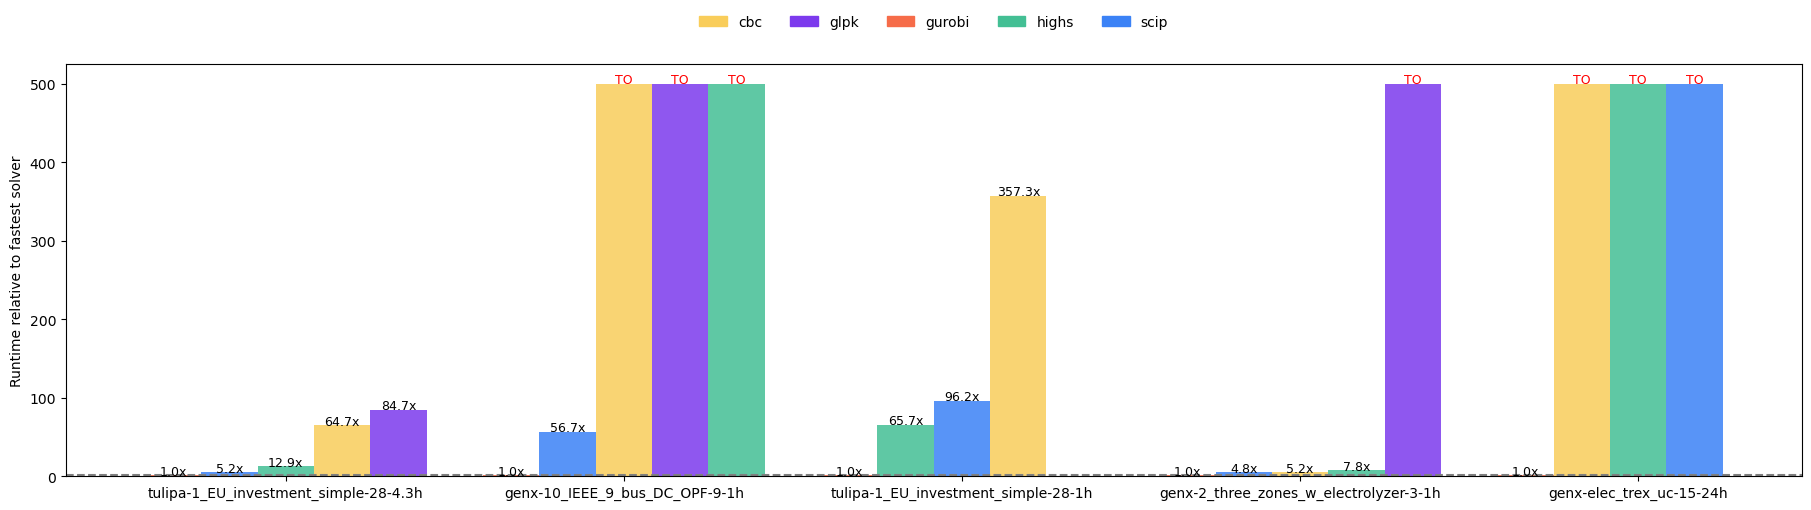

In [ ]:
# --- MILP feasibility plot ---

to_plot_milp = set(largest_milp_results["bench-size"])

to_plot_milp_results = results[results["bench-size"].isin(to_plot_milp)].copy()

to_plot_milp_results = to_plot_milp_results.sort_values(
    ["bench-size", "Solver", "Solver Release Year"]
).drop_duplicates(["bench-size", "Solver"], keep="last")

summary_feasible_milp = build_summary_single_benchmark(to_plot_milp_results)

fig, ax = plot_feasibility_runtime(
    summary_feasible_milp,
    figsize=(18, 5),
    cap=250,
)

fig.suptitle(
    "Largest MILP solvable by open-source solvers",
    fontsize=14,
    fontweight="bold",
    y=1.05,
)

In [ ]:
# The largest LP problems available, solveable by open solvers, and solvable by Gurobi for each model framework

# Largest LPs solveable by open solvers
largest_lp_per_model = (
    os_feasible_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")
)
# Add to this table the largest LP problems solveable by Gurobi
largest_lp_per_model = largest_lp_per_model.join(
    gurobi_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Gurobi",
)
# Add to this table the largest LP problems available
largest_lp_per_model = largest_lp_per_model.join(
    results_n_meta.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Available",
)
largest_lp_per_model = largest_lp_per_model.sort_values(
    "Num. Variables", ascending=False
)
largest_lp_per_model[
    [c for c in cols_of_interest if c != "Runtime - Gurobi"]
    + ["Num. Variables - Gurobi", "Num. Variables - Available"]
]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Num. Variables - Gurobi,Num. Variables - Available
Modelling Framework,,,,,,,,,,,
TIMES,TIMES-GEO-global-netzero,31-20ts,5422595,5063755,31 regions,20 time slices,highs,1.12.0,17 hours,6449851,6449851
PyPSA,pypsa-de-elec-trex_copt-dfp,10-1h,2111309,4502865,10 nodes,1 hour,highs,1.12.0,20 hours,8638003,52371864
TEMOA,temoa-US_9R_TS_NDC,9-12ts,1801794,1594091,9 regions,"12 time slices (4 seasons, 3 times of day)",highs,1.12.0,11 hours,1801794,1801794
ethos.fine,ethos-fine-energyland-full-timeseries,1-8760ts,473179,543229,1 node,8760 time slices,cbc,2.10.11,40 minutes,32770,473179
GenX,genx-8_three_zones_w_colocated_VRE_storage_ele...,3-1h,257129,302449,3 nodes,168 hour,cbc,2.10.12,49 minutes,13777201,13777201
OEMOF,OEMOF-simple-dispatch,1-8760ts,140160,96360,Single-node system with electricity and heat c...,8760 time slices,highs,1.5.0.dev0,a second,140160,140160
DCOPF,DCOPF-Carolinas_6M,997-1h,122017,199255,997 nodes,1 hour,highs,1.12.0,10 seconds,122017,122017
ZEN-garden,zen-garden-eur-PI,28-2ts,91744,126822,28 nodes,2 time slices,cbc,2.10.11,2 seconds,3105360,3105360
FINE,FINE-energyland,1-8760ts,32770,40198,1 node,8760 time slices,highs,1.9.0,27 seconds,32770,32770


In [ ]:
# The largest MILP problems available, solveable by open solvers, and solvable by Gurobi for each model framework

# Largest MILPs solveable by open solvers
largest_milp_per_model = (
    os_feasible_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")
)
# Add to this table the largest MILP problems solveable by Gurobi
largest_milp_per_model = largest_milp_per_model.join(
    gurobi_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Gurobi",
)
# Add to this table the largest MILP problems available
largest_milp_per_model = largest_milp_per_model.join(
    results_n_meta.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Available",
)
largest_milp_per_model = largest_milp_per_model.sort_values(
    "Num. Variables", ascending=False
)
largest_milp_per_model[
    [c for c in cols_of_interest if c != "Runtime - Gurobi"]
    + ["Num. Variables - Gurobi", "Num. Variables - Available"]
]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Num. Variables - Gurobi,Num. Variables - Available
Modelling Framework,,,,,,,,,,,
Tulipa,tulipa-1_EU_investment_simple,28-1h,1619451,2429440,28 nodes,1 hour,highs,1.12.0,3 hours,1619451,1619451
GenX,genx-10_IEEE_9_bus_DC_OPF,9-1h,639483,1235166,9 nodes,1 hour,scip,8.1.0,40 minutes,2551346,2551346
DCOPF,DCOPF-Carolinas_uc_6M,997-1h,131278,220143,997 nodes,1 hour,scip,8.1.0,50 minutes,131278,131278
PyPSA,pypsa-power+ely+battery-ucgas-mod,1-1h,113889,219009,1 node,1 hour,highs,1.12.0,2 minutes,113889,113889
OEMOF,OEMOF-economic-results,1-8760ts,61326,52567,Single-node system,8760 time slices,highs,1.6.0.dev0,a moment,61326,61326
ethos.fine,ethos-fine-multi-regional-7tp-12seg,8-84ts,33215,64214,8 nodes,84 time slices,highs,1.12.0,20 minutes,55979,55979
Sienna,Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate...,73-1h,29520,24192,73 nodes,48 hours,highs,1.12.0,47 minutes,38784,38784
FINE,FINE-multi-regional-energy-system-workflow,8-8760ts,16580,44954,8 nodes,8760 time slices,highs,1.6.0.dev0,15 seconds,16580,16580
PowerModels,pglib_opf_case2868,2868-NA,11045,25717,2868 nodes,NA,cbc,2.10.11,5 minutes,11045,11045


In [ ]:
def plot_largest_probs(largest_per_model, lp_or_milp, figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize, layout="constrained")
    width = 0.25

    # Plot the OS results
    xs = np.arange(len(largest_per_model)) + width
    colors = [color_map[s] for s in largest_per_model["Solver"]]
    ax.bar(xs, largest_per_model["Num. Variables"], width, color=colors)

    # Add text labels of slowdowns on top of bars
    for i, x in enumerate(xs):
        slowdown = (
            largest_per_model.iloc[i]["Runtime (s)"]
            / largest_per_model.iloc[i]["Runtime (s) - Gurobi"]
        )
        label = f"{slowdown:.1f}x"
        ax.text(
            x, largest_per_model.iloc[i]["Num. Variables"] * 1.01, label, ha="center"
        )

    # Plot Gurobi results
    xs = np.arange(len(largest_per_model))
    colors = [color_map["gurobi"] for s in largest_per_model["Solver"]]
    ax.bar(xs, largest_per_model["Num. Variables - Gurobi"], width, color=colors)

    # Plot the largest available problem per model
    xs = np.arange(len(largest_per_model)) - width
    colors = ["#DDD" for _ in largest_per_model["Solver"]]
    ax.bar(xs, largest_per_model["Num. Variables - Available"], width, color=colors)

    # Set x-ticks and labels
    xlabels = [f"{i}" for i, r in largest_per_model.iterrows()]
    ax.set_xticks(np.arange(len(largest_per_model)), xlabels)

    # Add labels and title
    ax.set_xlabel("Modelling Framework")
    ax.set_ylabel("Number of Variables")
    ax.set_title(
        f"Largest {lp_or_milp} problems available, solvable by Gurobi, and solvable by open solvers"
    )
    legend = {"available in set": "#DDD", **color_map}
    ax.legend(
        handles=[Patch(color=c, label=s) for s, c in legend.items()],
        loc="upper right",
    )

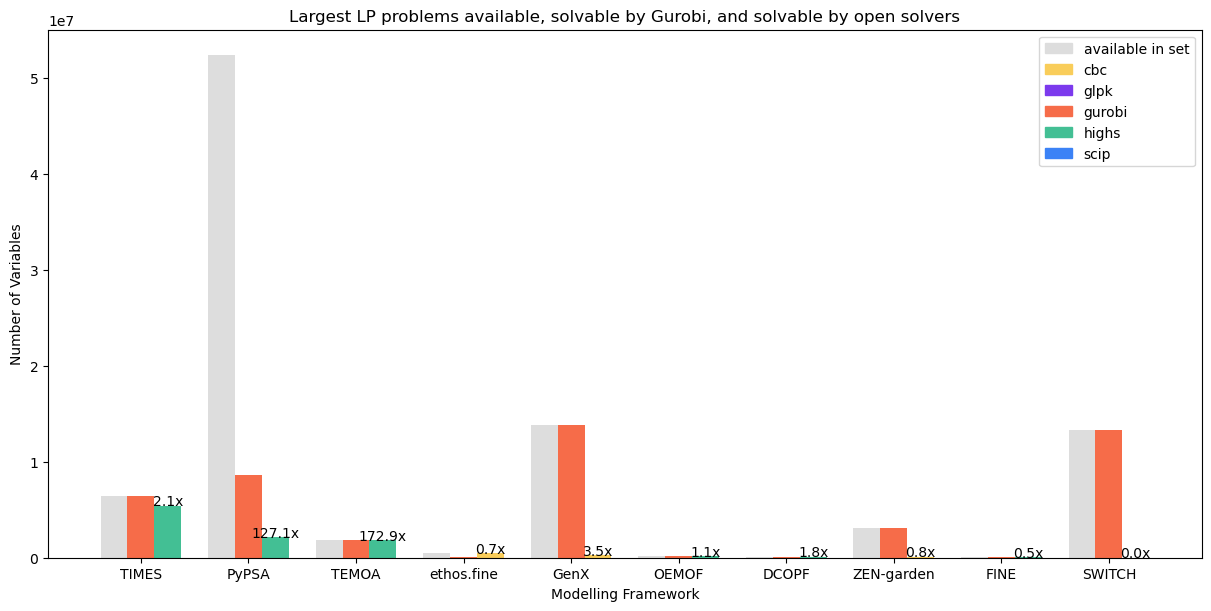

In [ ]:
plot_largest_probs(largest_lp_per_model, "LP")

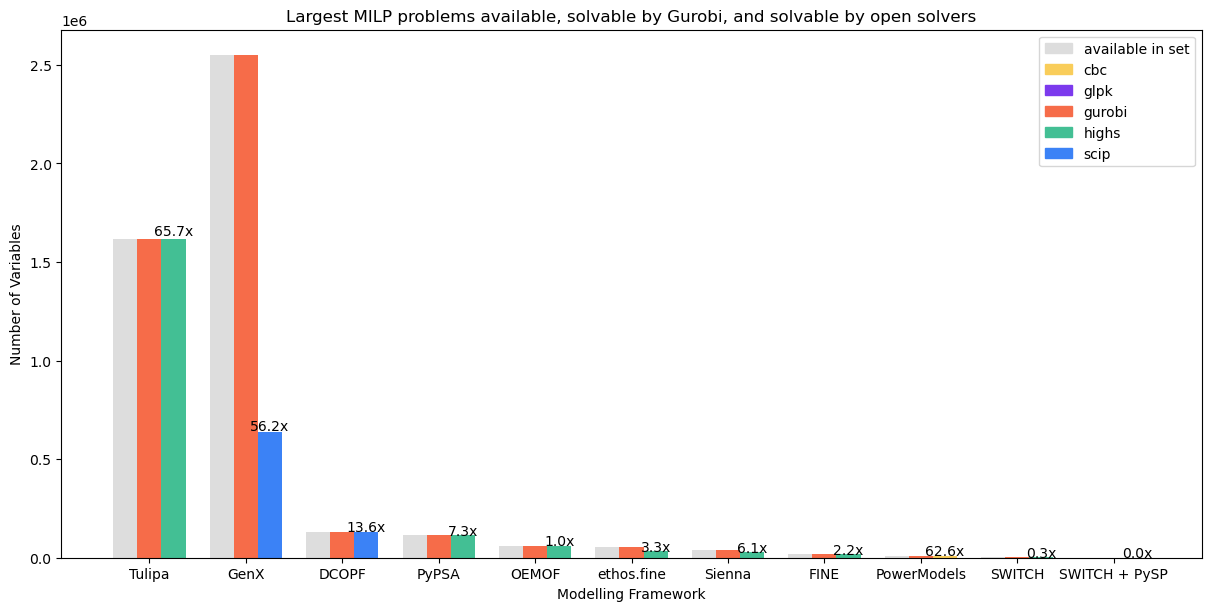

In [ ]:
plot_largest_probs(largest_milp_per_model, "MILP")

## What factors affect solver performance?

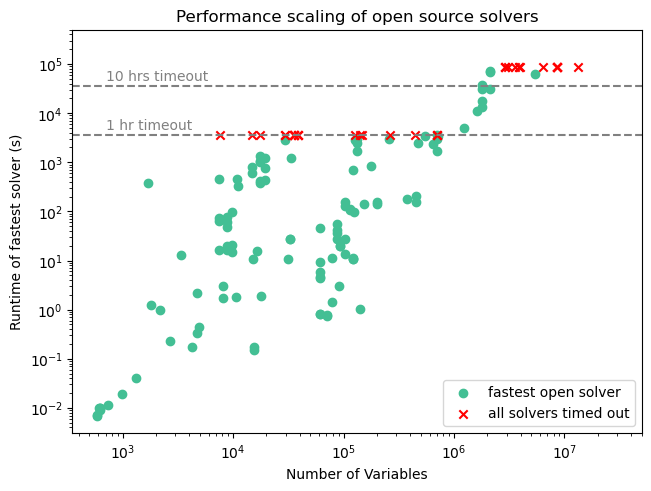

In [ ]:
# Runtime vs number of variables for OS solvers and Gurobi
def plot_runtime_vs_num_vars(results, TO_results, title, color, label):
    fig, ax = plt.subplots(layout="constrained")
    # Add a dotted line at timeouts
    ax.axhline(60 * 60, color="grey", linestyle="--")
    ax.text(7e2, 60 * 60 + 1000, "1 hr timeout", color="grey")
    ax.axhline(10 * 60 * 60, color="grey", linestyle="--")
    ax.text(7e2, 10 * 60 * 60 + 10000, "10 hrs timeout", color="grey")
    ax.scatter(
        results["Num. Variables"],
        results["Runtime (s)"],
        c=color,
        label=label,
    )
    ax.scatter(
        TO_results["Num. Variables"],
        TO_results["Timeout"],
        c="red",
        marker="x",
        label="all solvers timed out",
    )
    ax.set_yscale("log")
    ax.set_ylim(None, 5e5)
    ax.set_xscale("log")
    ax.set_xlim(None, 5e7)
    ax.set_xlabel("Number of Variables")
    ax.set_ylabel("Runtime of fastest solver (s)")
    ax.set_title(title)
    ax.legend(loc="lower right")


os_statuses = (
    results_n_meta.query("Solver != 'gurobi'").groupby("bench-size")["Status"].unique()
)
os_TO_results = (
    results_n_meta.set_index("bench-size")
    .loc[os_statuses.astype(str) == "['TO']"]
    .reset_index()
    .drop_duplicates(["bench-size"])
)
plot_runtime_vs_num_vars(
    os_feasible_results,
    os_TO_results,
    "Performance scaling of open source solvers",
    color_map["highs"],
    "fastest open solver",
)

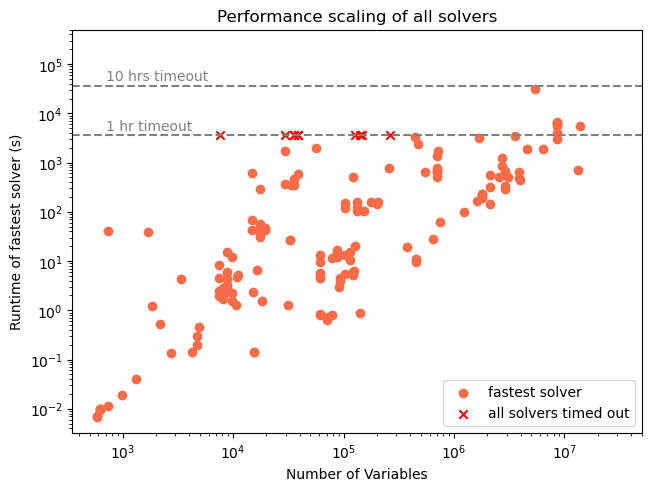

In [ ]:
all_solver_results = (
    results_n_meta.query("Status == 'ok'")
    .sort_values("Runtime (s)")
    .drop_duplicates(["bench-size"])
)
all_statuses = results_n_meta.groupby("bench-size")["Status"].unique()
all_TO_results = (
    results_n_meta.set_index("bench-size")
    .loc[all_statuses.astype(str) == "['TO']"]
    .reset_index()
    .drop_duplicates(["bench-size"])
)
plot_runtime_vs_num_vars(
    all_solver_results,
    all_TO_results,
    "Performance scaling of all solvers",
    color_map["gurobi"],
    "fastest solver",
)

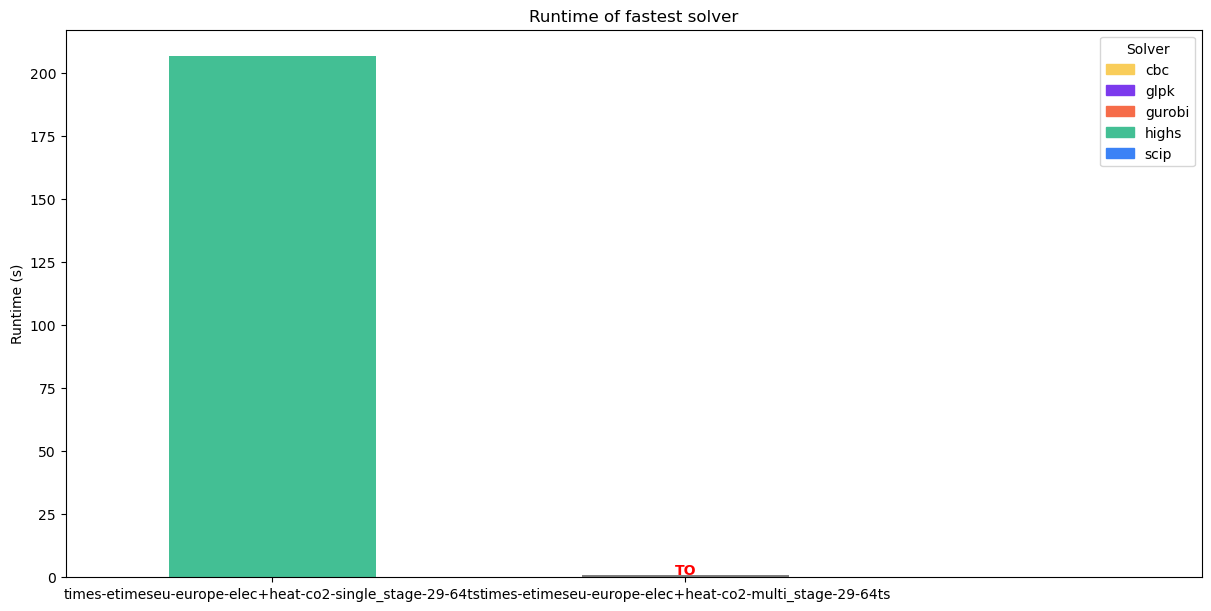

In [ ]:
# Un-normalized runtime bar charts of the fastest (open) solver for a set of problems
def plot_fastest_runtime_of(to_plot, figsize=(8, 6), os_only=True):
    df = results[results["bench-size"].isin(set(to_plot))]

    # Fill NaN runtimes and non-ok statuses with TO value
    df.loc[df["Runtime (s)"].isna(), "Runtime (s)"] = df["Timeout"]
    df.loc[df.query('Status != "ok"').index, "Runtime (s)"] = df["Timeout"]

    # Find the fastest solver for each benchmark
    if os_only:
        df_ok = df.query('Status == "ok" and Solver != "gurobi"')
    else:
        df_ok = df.query('Status == "ok"')
    fastest_runtimes = df_ok.loc[
        df_ok.groupby("bench-size")["Runtime (s)"].idxmin()
    ].set_index("bench-size")

    width = 0.5

    fig, ax = plt.subplots(figsize=figsize, layout="constrained")
    # Plot each benchmark
    for i, benchmark in enumerate(to_plot):
        if benchmark in fastest_runtimes.index:
            this_data = fastest_runtimes.loc[benchmark]
            colors = [color_map[this_data["Solver"]]]
            ax.bar([i], this_data["Runtime (s)"], width, color=colors)
        else:
            to_bar_height = 1
            ax.bar([i], to_bar_height, width, color=["grey"])
            ax.text(i, to_bar_height, "TO", ha="center", color="red", weight="bold")

    # Set x-ticks and labels
    xlabels = [f"{benchmark}" for benchmark in to_plot]
    ax.set_xticks(np.arange(len(to_plot)), xlabels)

    # Add labels and title
    ax.set_ylabel("Runtime (s)")
    ax.set_xlim(-0.5, len(to_plot) + 0.25)
    ax.set_title("Runtime of fastest solver")
    ax.legend(
        handles=[Patch(color=c, label=s) for s, c in color_map.items()],
        title="Solver",
        loc="upper right",
    )


plot_fastest_runtime_of(
    # ["temoa-US_9R_TS-9-12", "temoa-US_9R_TS_NDC-9-12", "temoa-US_9R_TS_NZ-9-12"],
    # [
    #     "genx-elec_trex-15-168h",
    #     "genx-elec_trex_co2-15-168h",
    #     "genx-elec_trex_uc-15-24h",
    #     "genx-elec_co2-15-168h",
    # ],
    [
        "times-etimeseu-europe-elec+heat-co2-single_stage-29-64ts",
        "times-etimeseu-europe-elec+heat-co2-multi_stage-29-64ts",
    ],
    figsize=(12, 6),
)

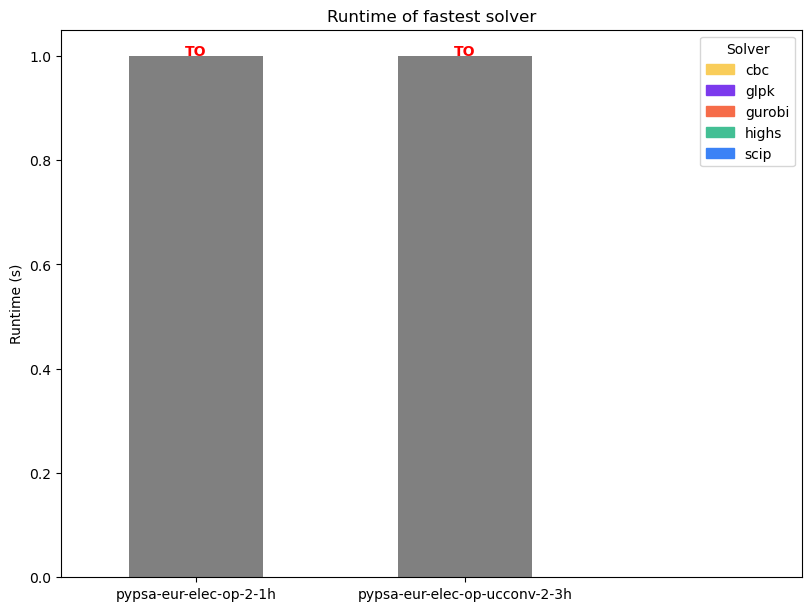

In [ ]:
# The effect of unit commitment (MILP feature) on PyPSA
plot_fastest_runtime_of(
    ["pypsa-eur-elec-op-2-1h", "pypsa-eur-elec-op-ucconv-2-3h"],
    figsize=(8, 6),
    os_only=False,
)

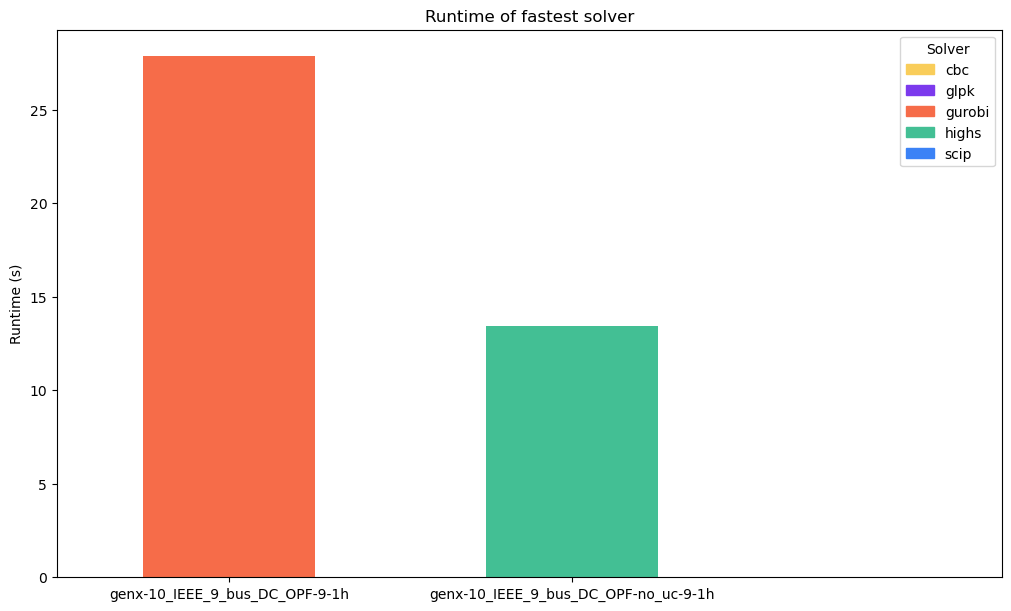

In [ ]:
# The effect of unit commitment (MILP feature) on GenX
plot_fastest_runtime_of(
    ["genx-10_IEEE_9_bus_DC_OPF-9-1h", "genx-10_IEEE_9_bus_DC_OPF-no_uc-9-1h"],
    figsize=(10, 6),
    os_only=False,
)

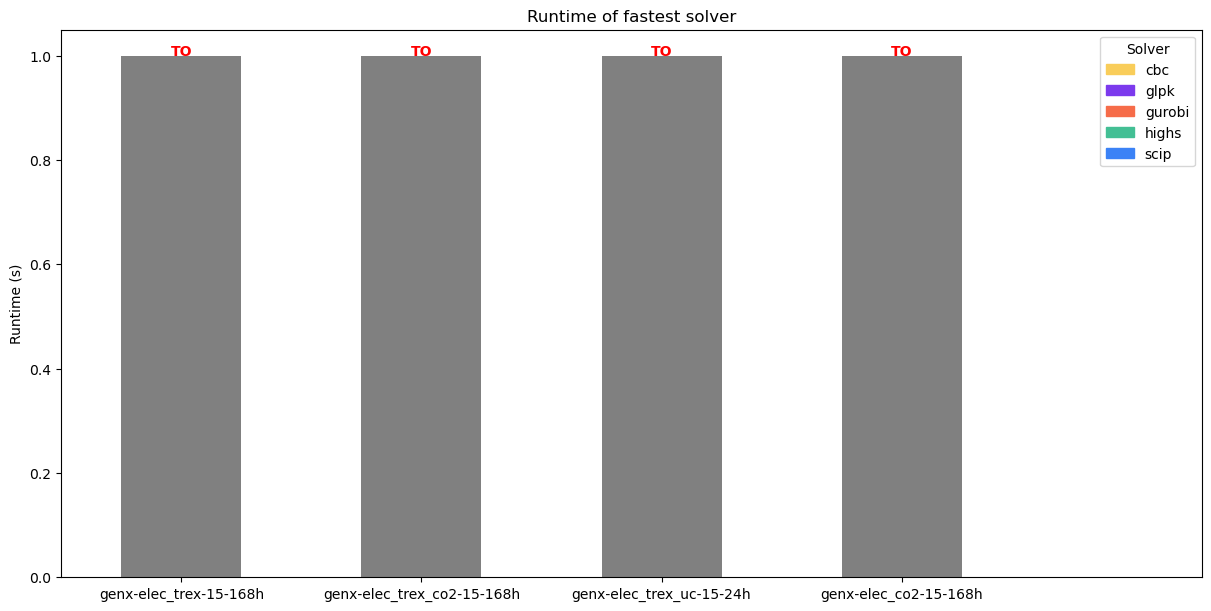

In [ ]:
# The effect of UC, transmission expansion, and CO2 constraints in GenX
plot_fastest_runtime_of(
    [
        "genx-elec_trex-15-168h",
        "genx-elec_trex_co2-15-168h",
        "genx-elec_trex_uc-15-24h",
        "genx-elec_co2-15-168h",
    ],
    figsize=(12, 6),
    # os_only=False,
)

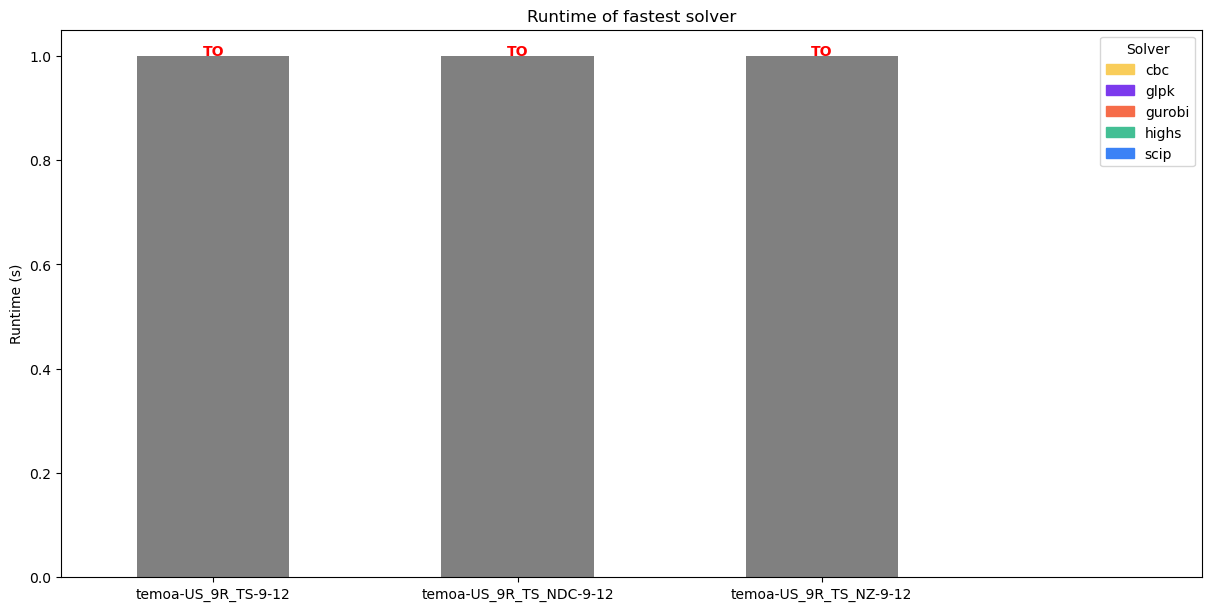

In [ ]:
# The effect of CO2 constraints in TEMOA
plot_fastest_runtime_of(
    ["temoa-US_9R_TS-9-12", "temoa-US_9R_TS_NDC-9-12", "temoa-US_9R_TS_NZ-9-12"],
    figsize=(12, 6),
    os_only=False,
)

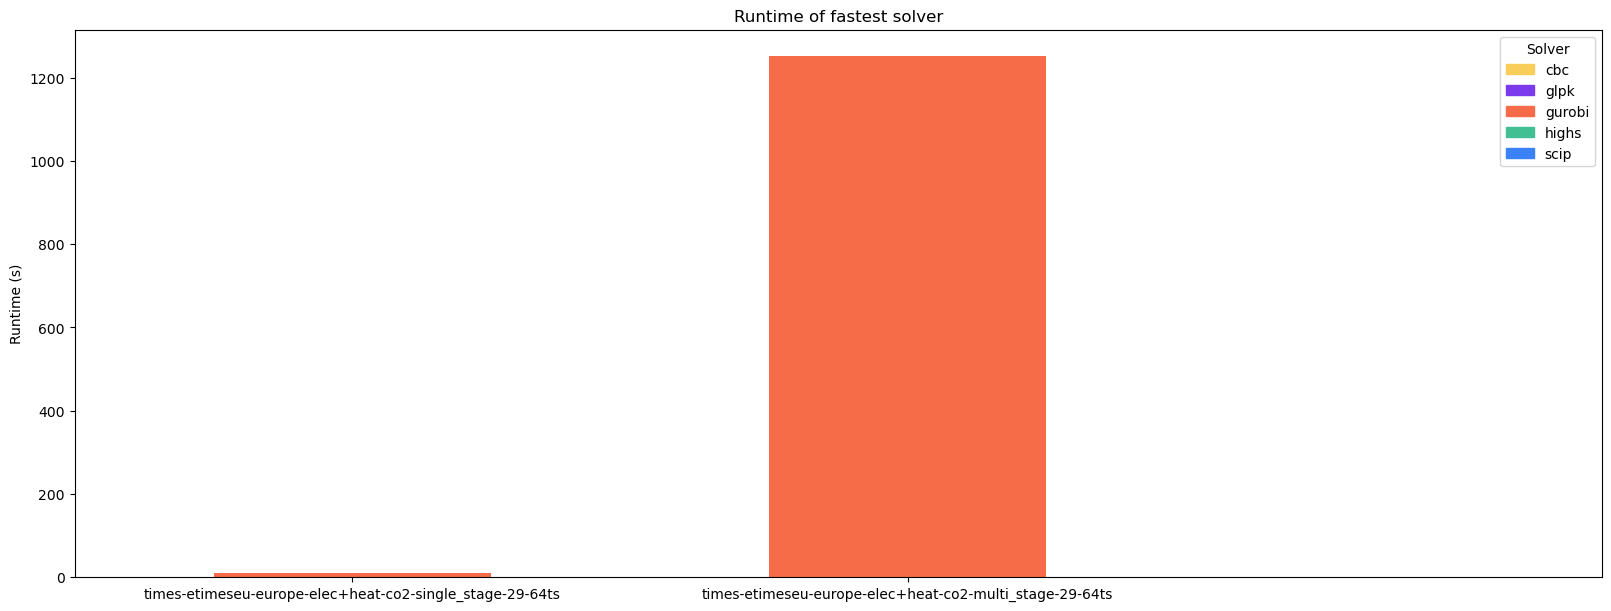

In [ ]:
# The effect of time horizons in TIMES
plot_fastest_runtime_of(
    [
        "times-etimeseu-europe-elec+heat-co2-single_stage-29-64ts",
        "times-etimeseu-europe-elec+heat-co2-multi_stage-29-64ts",
    ],
    figsize=(16, 6),
    os_only=False,
)

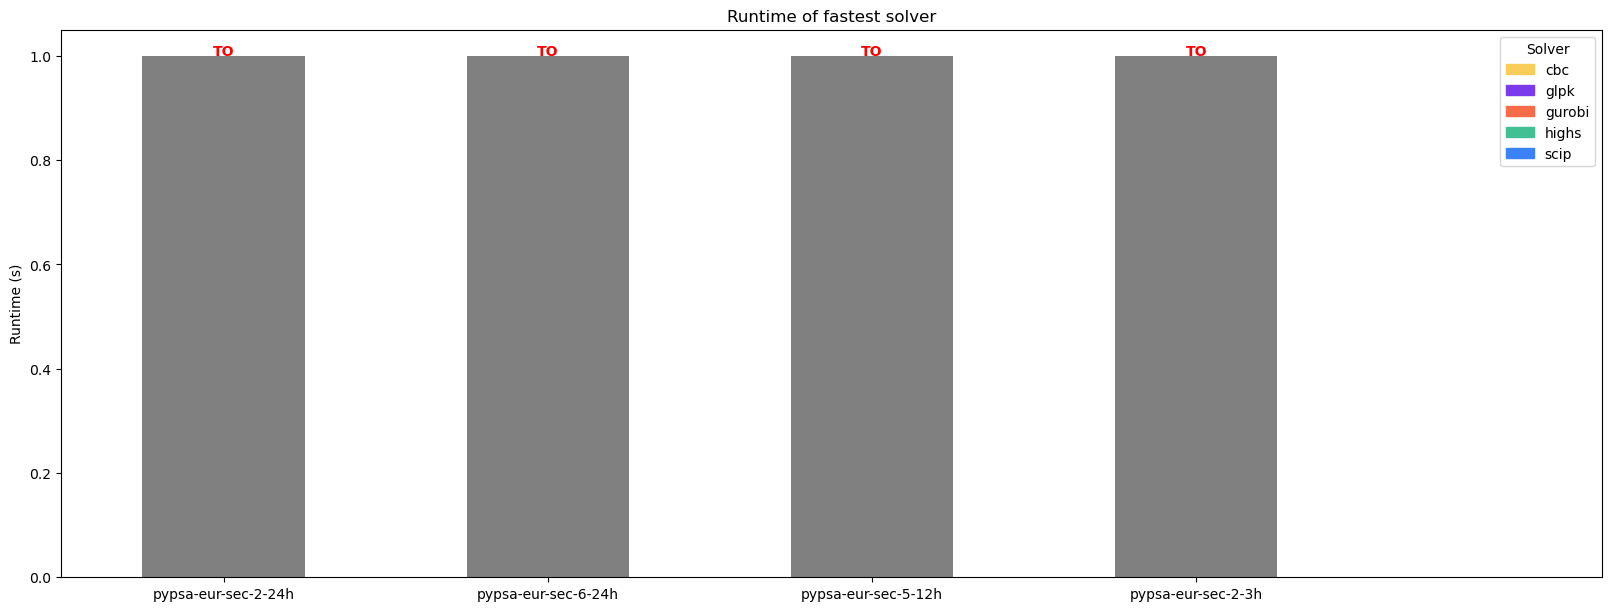

In [ ]:
# Different size instances of pypsa models
plot_fastest_runtime_of(
    [
        "pypsa-eur-sec-2-24h",
        "pypsa-eur-sec-6-24h",
        "pypsa-eur-sec-5-12h",
        "pypsa-eur-sec-2-3h",
    ],
    figsize=(16, 6),
    os_only=False,
)